In [4]:
# Celda 1: Importar Librerías y Módulos

import os
import numpy as np
import rasterio
from datetime import datetime
from tqdm import tqdm  # <-- MODIFICACIÓN: Cambiado de tqdm.notebook a solo tqdm

# Importar los módulos personalizados del paquete lcp
import lcp.data_loader as dl
import lcp.processing as proc
import lcp.pathfinder as pf
import lcp.utils as utils

print("Módulos cargados exitosamente.")

Módulos cargados exitosamente.


In [5]:
# ==============================================================================
# --- PARÁMETROS CONFIGURABLES POR EL USUARIO ---
# ==============================================================================
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Crear una carpeta de sesión única para cada ejecución
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = os.path.join(BASE_DIR, 'output', f'session_{timestamp}_AllToAll')

# --- Rutas a los datos de entrada ---
COST_RASTER_PATH = os.path.join(DATA_DIR, 'cost.tif')
ALL_POINTS_SHAPEFILE = os.path.join(DATA_DIR, 'points.shp')
MASK_SHAPEFILE_PATH = os.path.join(DATA_DIR, 'area-mask.shp') # Puede ser None si no se usa

# --- Parámetros de cálculo ---
# ORIGIN_POINT_ID ya no es necesario en un análisis "todos con todos"
ID_FIELD_NAME = 'id'
DOWNSAMPLING_FACTORS = [32, 20, 10]
CORRIDOR_BUFFER_PIXELS = 150
HEURISTIC_WEIGHT = 1.0

print(f"Configuración lista para el análisis 'Todos con Todos'.")
print(f"Los resultados se guardarán en: {OUTPUT_DIR}")

Configuración lista para el análisis 'Todos con Todos'.
Los resultados se guardarán en: G:\LCP\output\session_20250917_000950_AllToAll


In [6]:
# ==============================================================================
# --- EJECUCIÓN DEL ANÁLISIS (TODOS CON TODOS) ---
# ==============================================================================
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    all_points, points_crs = dl.load_points_as_dict(ALL_POINTS_SHAPEFILE, ID_FIELD_NAME)
    
    with dl.load_raster(COST_RASTER_PATH) as src:
        print("Cargando superficie de costo a memoria...")
        cost_data_high_res = src.read(1)
        
        if MASK_SHAPEFILE_PATH and os.path.exists(MASK_SHAPEFILE_PATH):
            main_search_mask = proc.create_mask_from_vector(MASK_SHAPEFILE_PATH, src)
        else:
            main_search_mask = np.ones_like(cost_data_high_res, dtype=bool)

        # Convertir el diccionario de puntos a una lista ordenada por ID para la iteración optimizada
        sorted_points = sorted(all_points.items())
        
        # --- BUCLE ANIDADO PARA EL CÁLCULO "TODOS CON TODOS" ---
        # Se usa tqdm para visualizar el progreso del bucle externo.
        for i, (origin_id, origin_coords) in enumerate(tqdm(sorted_points, desc="Progreso General (Orígenes)")):
            start_pixel_hr = proc.world_to_pixel(src.transform, origin_coords[0], origin_coords[1])
            
            # El bucle interno empieza desde el siguiente punto para evitar duplicados (A->B y B->A)
            for dest_id, dest_coords in sorted_points[i+1:]:
                
                print(f"\n" + "="*50)
                print(f"--- Calculando ruta: {origin_id} -> {dest_id} ---")
                print("="*50)
                end_pixel_hr = proc.world_to_pixel(src.transform, dest_coords[0], dest_coords[1])
                
                # FASE 1: Búsqueda a baja resolución
                path_found_lr, path_pixels_lr, successful_factor, trans_low = False, None, None, None
                print("-> FASE 1: Buscando en baja resolución...")
                for factor in DOWNSAMPLING_FACTORS:
                    # (El resto de la lógica de Fase 1 y Fase 2 es idéntica, solo cambian las variables de id)
                    print(f"  Intentando con factor de remuestreo {factor}x...")
                    cost_lr, trans_lr, dx_lr, dy_lr = proc.create_low_res_data(src, factor)
                    mask_lr = main_search_mask[::factor, ::factor]
                    start_lr = (start_pixel_hr[0] // factor, start_pixel_hr[1] // factor)
                    end_lr = (end_pixel_hr[0] // factor, end_pixel_hr[1] // factor)
                    found, came_from_lr = pf.a_star_search(cost_lr, src.nodata, start_lr, end_lr, dx_lr, abs(dy_lr), HEURISTIC_WEIGHT, mask_lr)
                    if found:
                        print(f"  Éxito con factor {factor}.")
                        path_found_lr, successful_factor, trans_low = True, factor, trans_lr
                        path_pixels_lr = pf.reconstruct_path(came_from_lr, start_lr, end_lr)
                        break
                    else: print(f"  Falló con factor {factor}.")
                
                # FASE 2: Búsqueda a alta resolución
                print("\n-> FASE 2: Buscando en alta resolución...")
                path_found_hr, came_from_hr = False, None
                if path_found_lr and path_pixels_lr is not None:
                    print("  Creando corredor...")
                    corridor_mask = proc.create_search_corridor(path_pixels_lr, cost_data_high_res.shape, successful_factor, CORRIDOR_BUFFER_PIXELS)
                    final_search_mask = np.logical_and(corridor_mask, main_search_mask)
                    path_found_hr, came_from_hr = pf.a_star_search(cost_data_high_res, src.nodata, start_pixel_hr, end_pixel_hr, src.res[0], abs(src.res[1]), HEURISTIC_WEIGHT, final_search_mask)
                if not path_found_hr:
                    print("  Búsqueda en corredor fallida o no realizada. Iniciando PLAN B...")
                    path_found_hr, came_from_hr = pf.a_star_search(cost_data_high_res, src.nodata, start_pixel_hr, end_pixel_hr, src.res[0], abs(src.res[1]), HEURISTIC_WEIGHT, main_search_mask)

                # Guardar resultados
                if path_found_hr:
                    print(f"  ÉXITO FINAL: Se encontró la ruta para {origin_id} -> {dest_id}.")
                    path_pixels_hr = pf.reconstruct_path(came_from_hr, start_pixel_hr, end_pixel_hr)
                    if path_pixels_lr is not None:
                        p1_path = os.path.join(OUTPUT_DIR, f"ruta_fase1_{origin_id}_a_{dest_id}.shp")
                        utils.save_path_to_shapefile(path_pixels_lr, trans_low, src.crs, p1_path)
                    final_path_shp = os.path.join(OUTPUT_DIR, f"ruta_final_{origin_id}_a_{dest_id}.shp")
                    utils.save_path_to_shapefile(path_pixels_hr, src.transform, src.crs, final_path_shp)
                else:
                    print(f"  ERROR CRÍTICO: No se pudo encontrar ninguna ruta para {origin_id} -> {dest_id}.")

except Exception as e:
    print(f"\nOcurrió un error fatal en la ejecución: {e}")
    import traceback
    traceback.print_exc()
finally:
    print("\n" + "="*50 + "\n--- ANÁLISIS 'TODOS CON TODOS' COMPLETADO ---\n" + "="*50)

Cargando puntos desde: G:\LCP\data\points.shp
Se cargaron 14 puntos.
Cargando raster desde: G:\LCP\data\cost.tif
Raster cargado exitosamente.
Cargando superficie de costo a memoria...
Creando máscara booleana desde el polígono...
Máscara creada.


Progreso General (Orígenes):   0%|                                                              | 0/14 [00:00<?, ?it/s]


--- Calculando ruta: 1 -> 2 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Falló con factor 32.
  Intentando con factor de remuestreo 20x...
  Éxito con factor 20.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 1 -> 2.
Ruta guardada exitosamente en: ruta_fase1_1_a_2.shp
Ruta guardada exitosamente en: ruta_final_1_a_2.shp

--- Calculando ruta: 1 -> 3 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 1 -> 3.
Ruta guardada exitosamente en: ruta_fase1_1_a_3.shp
Ruta guardada exitosamente en: ruta_final_1_a_3.shp

--- Calculando ruta: 1 -> 4 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉX

Progreso General (Orígenes):   7%|███▊                                                  | 1/14 [01:06<14:20, 66.20s/it]

  ÉXITO FINAL: Se encontró la ruta para 1 -> 13.
Ruta guardada exitosamente en: ruta_fase1_1_a_13.shp
Ruta guardada exitosamente en: ruta_final_1_a_13.shp

--- Calculando ruta: 1 -> 14 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Falló con factor 32.
  Intentando con factor de remuestreo 20x...
  Éxito con factor 20.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 1 -> 14.
Ruta guardada exitosamente en: ruta_fase1_1_a_14.shp
Ruta guardada exitosamente en: ruta_final_1_a_14.shp

--- Calculando ruta: 2 -> 3 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 2 -> 3.
Ruta guardada exitosamente en: ruta_fase1_2_a_3.shp
Ruta guardada exitosamente en: ruta_final_2_a_3.shp

--- Calculando ruta: 2 -> 4 ---
-> FASE 1: Buscando 

Progreso General (Orígenes):  14%|███████▋                                              | 2/14 [02:16<13:44, 68.69s/it]

  ÉXITO FINAL: Se encontró la ruta para 2 -> 14.
Ruta guardada exitosamente en: ruta_fase1_2_a_14.shp
Ruta guardada exitosamente en: ruta_final_2_a_14.shp

--- Calculando ruta: 3 -> 4 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 3 -> 4.
Ruta guardada exitosamente en: ruta_fase1_3_a_4.shp
Ruta guardada exitosamente en: ruta_final_3_a_4.shp

--- Calculando ruta: 3 -> 5 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 3 -> 5.
Ruta guardada exitosamente en: ruta_fase1_3_a_5.shp
Ruta guardada exitosamente en: ruta_final_3_a_5.shp

--- Calculando ruta: 3 -> 6 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxi

Progreso General (Orígenes):  21%|███████████▌                                          | 3/14 [03:19<12:07, 66.17s/it]

  ÉXITO FINAL: Se encontró la ruta para 3 -> 14.
Ruta guardada exitosamente en: ruta_fase1_3_a_14.shp
Ruta guardada exitosamente en: ruta_final_3_a_14.shp

--- Calculando ruta: 4 -> 5 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 4 -> 5.
Ruta guardada exitosamente en: ruta_fase1_4_a_5.shp
Ruta guardada exitosamente en: ruta_final_4_a_5.shp

--- Calculando ruta: 4 -> 6 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 4 -> 6.
Ruta guardada exitosamente en: ruta_fase1_4_a_6.shp
Ruta guardada exitosamente en: ruta_final_4_a_6.shp

--- Calculando ruta: 4 -> 7 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxi

Progreso General (Orígenes):  29%|███████████████▍                                      | 4/14 [04:19<10:37, 63.74s/it]

  ÉXITO FINAL: Se encontró la ruta para 4 -> 14.
Ruta guardada exitosamente en: ruta_fase1_4_a_14.shp
Ruta guardada exitosamente en: ruta_final_4_a_14.shp

--- Calculando ruta: 5 -> 6 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 5 -> 6.
Ruta guardada exitosamente en: ruta_fase1_5_a_6.shp
Ruta guardada exitosamente en: ruta_final_5_a_6.shp

--- Calculando ruta: 5 -> 7 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 5 -> 7.
Ruta guardada exitosamente en: ruta_fase1_5_a_7.shp
Ruta guardada exitosamente en: ruta_final_5_a_7.shp

--- Calculando ruta: 5 -> 8 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxi

Progreso General (Orígenes):  36%|███████████████████▎                                  | 5/14 [05:31<10:00, 66.70s/it]

  ÉXITO FINAL: Se encontró la ruta para 5 -> 14.
Ruta guardada exitosamente en: ruta_fase1_5_a_14.shp
Ruta guardada exitosamente en: ruta_final_5_a_14.shp

--- Calculando ruta: 6 -> 7 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 6 -> 7.
Ruta guardada exitosamente en: ruta_fase1_6_a_7.shp
Ruta guardada exitosamente en: ruta_final_6_a_7.shp

--- Calculando ruta: 6 -> 8 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 6 -> 8.
Ruta guardada exitosamente en: ruta_fase1_6_a_8.shp
Ruta guardada exitosamente en: ruta_final_6_a_8.shp

--- Calculando ruta: 6 -> 9 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxi

Progreso General (Orígenes):  43%|███████████████████████▏                              | 6/14 [07:00<09:54, 74.25s/it]

  ÉXITO FINAL: Se encontró la ruta para 6 -> 14.
Ruta guardada exitosamente en: ruta_fase1_6_a_14.shp
Ruta guardada exitosamente en: ruta_final_6_a_14.shp

--- Calculando ruta: 7 -> 8 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 7 -> 8.
Ruta guardada exitosamente en: ruta_fase1_7_a_8.shp
Ruta guardada exitosamente en: ruta_final_7_a_8.shp

--- Calculando ruta: 7 -> 9 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 7 -> 9.
Ruta guardada exitosamente en: ruta_fase1_7_a_9.shp
Ruta guardada exitosamente en: ruta_final_7_a_9.shp

--- Calculando ruta: 7 -> 10 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éx

Progreso General (Orígenes):  50%|███████████████████████████                           | 7/14 [07:57<07:59, 68.45s/it]

  ÉXITO FINAL: Se encontró la ruta para 7 -> 14.
Ruta guardada exitosamente en: ruta_fase1_7_a_14.shp
Ruta guardada exitosamente en: ruta_final_7_a_14.shp

--- Calculando ruta: 8 -> 9 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 8 -> 9.
Ruta guardada exitosamente en: ruta_fase1_8_a_9.shp
Ruta guardada exitosamente en: ruta_final_8_a_9.shp

--- Calculando ruta: 8 -> 10 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 8 -> 10.
Ruta guardada exitosamente en: ruta_fase1_8_a_10.shp
Ruta guardada exitosamente en: ruta_final_8_a_10.shp

--- Calculando ruta: 8 -> 11 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...


Progreso General (Orígenes):  57%|██████████████████████████████▊                       | 8/14 [08:30<05:42, 57.14s/it]

  ÉXITO FINAL: Se encontró la ruta para 8 -> 14.
Ruta guardada exitosamente en: ruta_fase1_8_a_14.shp
Ruta guardada exitosamente en: ruta_final_8_a_14.shp

--- Calculando ruta: 9 -> 10 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 9 -> 10.
Ruta guardada exitosamente en: ruta_fase1_9_a_10.shp
Ruta guardada exitosamente en: ruta_final_9_a_10.shp

--- Calculando ruta: 9 -> 11 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 9 -> 11.
Ruta guardada exitosamente en: ruta_fase1_9_a_11.shp
Ruta guardada exitosamente en: ruta_final_9_a_11.shp

--- Calculando ruta: 9 -> 12 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x

Progreso General (Orígenes):  64%|██████████████████████████████████▋                   | 9/14 [08:56<03:57, 47.43s/it]

  ÉXITO FINAL: Se encontró la ruta para 9 -> 14.
Ruta guardada exitosamente en: ruta_fase1_9_a_14.shp
Ruta guardada exitosamente en: ruta_final_9_a_14.shp

--- Calculando ruta: 10 -> 11 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 10 -> 11.
Ruta guardada exitosamente en: ruta_fase1_10_a_11.shp
Ruta guardada exitosamente en: ruta_final_10_a_11.shp

--- Calculando ruta: 10 -> 12 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 10 -> 12.
Ruta guardada exitosamente en: ruta_fase1_10_a_12.shp
Ruta guardada exitosamente en: ruta_final_10_a_12.shp

--- Calculando ruta: 10 -> 13 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remue

Progreso General (Orígenes):  71%|█████████████████████████████████████▊               | 10/14 [09:16<02:36, 39.04s/it]

  ÉXITO FINAL: Se encontró la ruta para 10 -> 14.
Ruta guardada exitosamente en: ruta_fase1_10_a_14.shp
Ruta guardada exitosamente en: ruta_final_10_a_14.shp

--- Calculando ruta: 11 -> 12 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 11 -> 12.
Ruta guardada exitosamente en: ruta_fase1_11_a_12.shp
Ruta guardada exitosamente en: ruta_final_11_a_12.shp

--- Calculando ruta: 11 -> 13 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 11 -> 13.
Ruta guardada exitosamente en: ruta_fase1_11_a_13.shp
Ruta guardada exitosamente en: ruta_final_11_a_13.shp

--- Calculando ruta: 11 -> 14 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de re

Progreso General (Orígenes):  79%|█████████████████████████████████████████▋           | 11/14 [09:21<01:26, 28.71s/it]

  ÉXITO FINAL: Se encontró la ruta para 11 -> 14.
Ruta guardada exitosamente en: ruta_fase1_11_a_14.shp
Ruta guardada exitosamente en: ruta_final_11_a_14.shp

--- Calculando ruta: 12 -> 13 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Éxito con factor 32.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...
  ÉXITO FINAL: Se encontró la ruta para 12 -> 13.
Ruta guardada exitosamente en: ruta_fase1_12_a_13.shp
Ruta guardada exitosamente en: ruta_final_12_a_13.shp

--- Calculando ruta: 12 -> 14 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Falló con factor 32.
  Intentando con factor de remuestreo 20x...
  Éxito con factor 20.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...


Progreso General (Orígenes):  86%|█████████████████████████████████████████████▍       | 12/14 [09:22<00:40, 20.27s/it]

  ÉXITO FINAL: Se encontró la ruta para 12 -> 14.
Ruta guardada exitosamente en: ruta_fase1_12_a_14.shp
Ruta guardada exitosamente en: ruta_final_12_a_14.shp

--- Calculando ruta: 13 -> 14 ---
-> FASE 1: Buscando en baja resolución...
  Intentando con factor de remuestreo 32x...
  Falló con factor 32.
  Intentando con factor de remuestreo 20x...
  Éxito con factor 20.

-> FASE 2: Buscando en alta resolución...
  Creando corredor...


Progreso General (Orígenes): 100%|█████████████████████████████████████████████████████| 14/14 [09:23<00:00, 40.22s/it]

  ÉXITO FINAL: Se encontró la ruta para 13 -> 14.
Ruta guardada exitosamente en: ruta_fase1_13_a_14.shp
Ruta guardada exitosamente en: ruta_final_13_a_14.shp

--- ANÁLISIS 'TODOS CON TODOS' COMPLETADO ---


Iniciando la visualización de la red completa de rutas...


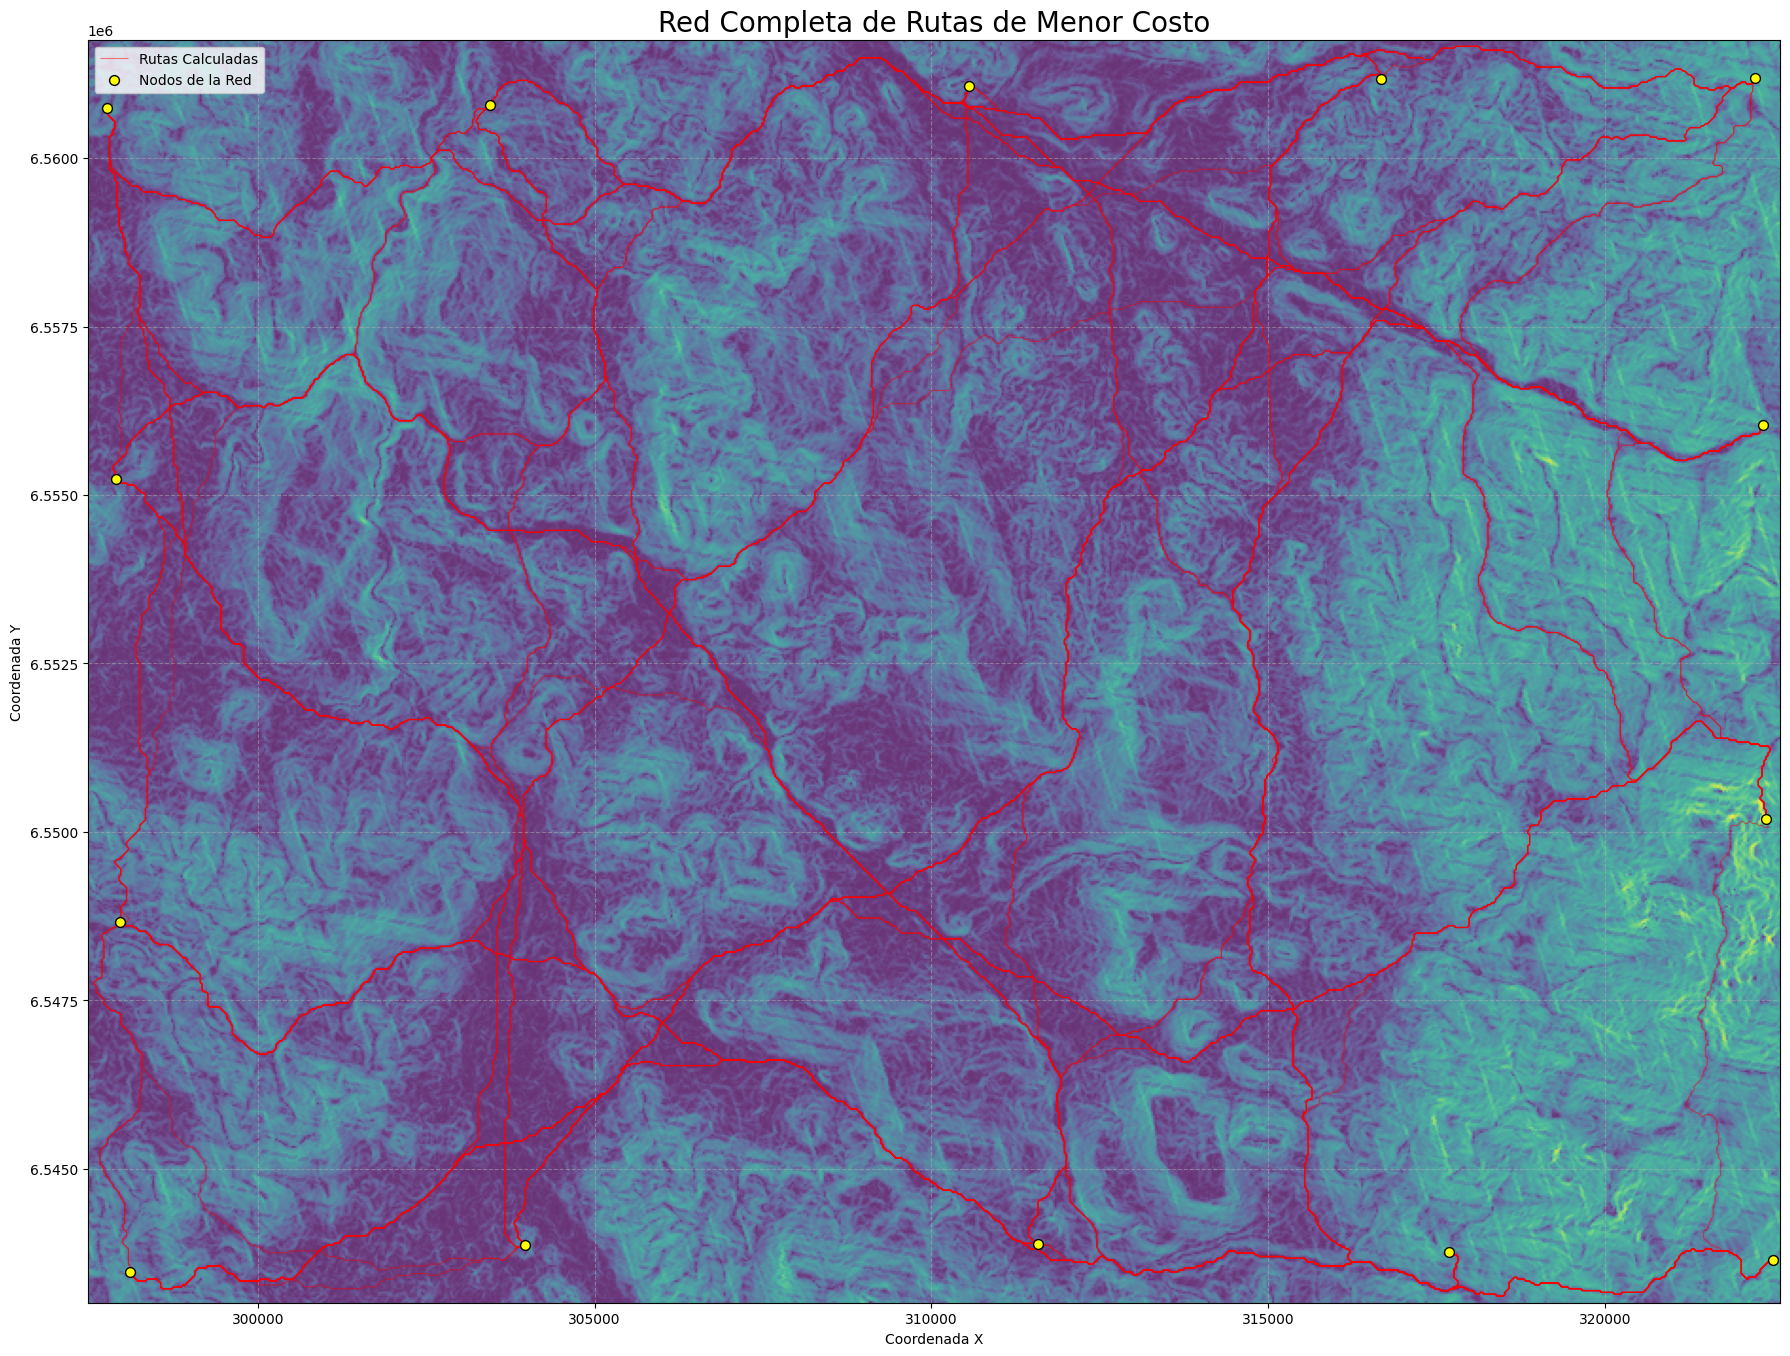

In [7]:
# ==============================================================================
# --- CELDA 4: VISUALIZACIÓN DE LA RED COMPLETA (TODOS CON TODOS) ---
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.plot
from rasterio.windows import from_bounds
import glob

print("Iniciando la visualización de la red completa de rutas...")

try:
    # --- 1. Encontrar y cargar TODAS las rutas generadas ---
    # MODIFICACIÓN: El patrón glob ahora busca cualquier ruta final, sin especificar origen.
    final_route_files = glob.glob(os.path.join(OUTPUT_DIR, 'ruta_final_*.shp'))

    if not final_route_files:
        print("No se encontraron archivos de rutas finales para visualizar.")
    else:
        # Cargar todas las rutas en un único GeoDataFrame
        final_routes_gdf = pd.concat([gpd.read_file(f) for f in final_route_files], ignore_index=True)
        
        # --- 2. Determinar la extensión total con margen ---
        minx, miny, maxx, maxy = final_routes_gdf.total_bounds
        margin = 100
        buffered_bounds = (minx - margin, miny - margin, maxx + margin, maxy + margin)
        
        # --- 3. Cargar la porción del raster ---
        with rasterio.open(COST_RASTER_PATH) as src:
            window = from_bounds(*buffered_bounds, transform=src.transform)
            raster_data = src.read(1, window=window)
            window_transform = src.window_transform(window)

        # --- 4. Cargar todos los puntos ---
        points_gdf = gpd.read_file(ALL_POINTS_SHAPEFILE)

        # --- 5. Crear el mapa ---
        fig, ax = plt.subplots(figsize=(18, 18))
        rasterio.plot.show(raster_data, transform=window_transform, ax=ax, cmap='viridis', norm=LogNorm(), alpha=0.8)
        
        # MODIFICACIÓN: Dibujar todas las rutas con alta transparencia y líneas finas
        final_routes_gdf.plot(
            ax=ax,
            edgecolor='red',
            linewidth=0.8,  # Líneas más finas
            label='Rutas Calculadas',
            alpha=0.5,      # Alta transparencia para ver superposiciones
            zorder=3
        )
        
        # MODIFICACIÓN: Dibujar todos los puntos con el mismo estilo
        points_gdf.plot(
            ax=ax,
            color='yellow',
            markersize=50,
            ec='black',
            label='Nodos de la Red',
            zorder=5
        )

        # Configuración final del mapa
        ax.set_title('Red Completa de Rutas de Menor Costo', fontsize=20)
        ax.set_xlabel("Coordenada X"); ax.set_ylabel("Coordenada Y")
        ax.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

except Exception as e:
    print(f"Ocurrió un error durante la visualización: {e}")
    import traceback
    traceback.print_exc()